<a href="https://colab.research.google.com/github/pabloswfly/mcmcgan/blob/master/Discriminator_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that we have learn to do demographic simulations with msprime, we can start building our discriminator with the permutation invariance property. The discriminator in the beginning will tell apart simulations with a difference in a single parameter, such as mutation rate, recombination rate, effective size, etc.

In [0]:
# Installing required libraries
!apt-get install python-dev libgsl0-dev
!python3 -m pip install msprime stdpopsim
!pip install zarr

In [0]:
# Importing libraries and modules
import msprime, stdpopsim, zarr, random, imageio, bisect
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Mount my Gdrive disk
from google.colab import drive, files
drive.mount('/content/gdrive')
!mkdir /content/results

In [0]:
def fixed_size_geno(ts, x):
  """Returns a genotype matrix with a fixed number of columns, as specified in x"""
  
  m = np.zeros((ts.num_samples, x), dtype=float)

  for variant in ts.variants():
      j = int(variant.site.position * x / ts.sequence_length)
      m[:, j] += variant.genotypes

  return m



def scale_matrix(m):
  """Scale matrix values to [-1, 1] range"""
  return (m*2/np.max(m) - 1)



def draw_genmat(img, name):
  
  plt.imshow(img, cmap="winter")
  plt.title(f'genomat_{name}')
  plt.savefig(f'genomat_{name}.png')
  plt.show()



def simulate_msprime(samples, seqlen, n_reps, fixed_size, param, seed=None, scale=True, 
                     param_name='recomb'):
  """Simulate demographic data, returning a tensor with n_reps number of genotype matrices"""

  if param_name=='recomb':
    sims = msprime.simulate(sample_size=samples, Ne=10000, length=seqlen, mutation_rate=1e-8, 
              recombination_rate=param, num_replicates=n_reps, random_seed=seed)
    
  elif param_name=='mutation':
    sims = msprime.simulate(sample_size=samples, Ne=10000, length=seqlen, mutation_rate=param, 
              recombination_rate=1e-8, num_replicates=n_reps, random_seed=seed)
    
  elif param_name=='effective':
    sims = msprime.simulate(sample_size=samples, Ne=param, length=seqlen, mutation_rate=1e-8, 
              recombination_rate=1e-8, num_replicates=n_reps, random_seed=seed)
    
  elif param_name=='growth':
    popconfig = msprime.PopulationConfiguration(sample_size=samples, growth_rate=param)
    sims = msprime.simulate(Ne=10000, length=seqlen, mutation_rate=1e-8, recombination_rate=1e-8, 
                            num_replicates=n_reps, random_seed=seed, 
                            population_configurations=popconfig)

  mat = np.zeros((n_reps, samples, fixed_size))

  # For each tree sequence output from the simulation
  for i, treeseq in enumerate(sims):
    mat[i] = fixed_size_geno(treeseq, fixed_size)

  # Scale genotype matrices from [0, 1] to [-1, 1].
  # If we were to use a generator, this scale should be done with tanh function
  if scale:
    mat = scale_matrix(mat)

  # Expand dimension by 1 (add channel dim). -1 stands for last axis.
  mat = np.expand_dims(mat, axis=-1)

  return mat



def simulate_msprime_list(samples, seqlen, fixed_size, params, seed=None, scale=True, 
                          param_name='recomb'):
  """Simulate demographic data, returning a tensor with n_reps number of 
  genotype matrices. Recombination rate is a list of values, not a single scalar"""

  sims = []
  n_reps = len(params)

  if param_name=='recomb':
    for p in params:
      sims.append(msprime.simulate(sample_size=samples, Ne=10000, length=seqlen, 
                                   mutation_rate=1e-8, recombination_rate=p, random_seed=seed))
    
  elif param_name=='mutation':
    for p in params:
      sims.append(msprime.simulate(sample_size=samples, Ne=10000, length=seqlen, mutation_rate=p, 
                                   recombination_rate=1e-8, random_seed=seed))
  
  elif param_name=='effective':
    for p in params:
      sims.append(msprime.simulate(sample_size=samples, Ne=p, length=seqlen, mutation_rate=1e-8, 
                                   recombination_rate=1e-8, random_seed=seed))
      
  elif param_name=='growth':
    for p in params:
      popconfig = msprime.PopulationConfiguration(sample_size=samples, growth_rate=p)
      sims = msprime.simulate(Ne=10000, length=seqlen, mutation_rate=1e-8, recombination_rate=1e-8, 
                      num_replicates=n_reps, random_seed=seed, population_configurations=popconfig)

  mat = np.zeros((n_reps, samples, fixed_size))

  # For each tree sequence output from the simulation
  for i, treeseq in enumerate(sims):
    mat[i] = fixed_size_geno(treeseq, fixed_size)

  # Scale genotype matrices from [0, 1] to [-1, 1].
  # If we were to use a generator, this scale should be done with tanh function
  if scale:
    mat = scale_matrix(mat)

  # Expand dimension by 1 (add channel dim). -1 stands for last axis.
  mat = np.expand_dims(mat, axis=-1)

  return mat



def generate_realdata(samples, seqlen, n_reps, fixed_size, scale=True):

  # Set up some data paths
  mask_file = "/content/gdrive/My Drive/mcmcgan/20140520.pilot_mask.autosomes.bed"
  zarr_path = "/content/gdrive/My Drive/mcmcgan/zarr"

  # Localte the data contained in zarr
  callset = zarr.open_group(zarr_path, mode='r')
  n_samples = len(callset['1/samples'])

  real_data = np.zeros((n_reps, n_samples, fixed_size))

  # Get lists of randomly selected chromosomes and genomic locations
  chroms, pos, slices = random_sampling_geno(callset, seqlen, n_reps, mask_file=mask_file)

  # For each randomly sampled genomic location
  for i, (chrom, pos, loc_region) in enumerate(zip(chroms, pos, slices)):
    print(f'it {i}  :  chromosome {chrom}  :  position {pos}')

    # Extract genotype and genomic position for the variants for all samples
    gt_zarr = np.asarray(callset[f'{chrom}/calldata/GT'][loc_region])
    pos_zarr = callset[f'{chrom}/variants/POS'][loc_region]

    # Make sure the genome is diploid, and extract one of the haplotypes
    assert gt_zarr.shape[2] is 2, "Samples are not diploid"
    hap = haploidify(gt_zarr, h=0)

    # Get the relative position in the sequence length to resize the matrix
    relative_pos = pos_zarr - pos
    real_data[i] = resize(hap, relative_pos, fixed_size, seqlen)

  if scale:
    real_data = scale_matrix(real_data)

  real_data = np.expand_dims(real_data, axis=-1)
  
  return real_data



def generate_data(samples, seqlen, n_reps, genmat_cols, param_name, fixed, low, high, 
                  minuslog=True, scale=True, source='msprime'):
  #Generate (X, y) data from demographic simulations.

  print(f'generating {n_reps} genotype matrices from {source}')
  if source=='stdpopsim':
    gen0 = simulate_stdpopsim(engine='msprime', species='HomSap', 
                        model='OutOfAfricaArchaicAdmixture_5R19', pop='CEU', samples=samples, 
                        seqlen=seqlen, reps=n_reps, scale=scale, genmat_cols=genmat_cols, 
                        error_prob=None)
    
  elif source=='real data':
    gen0 = generate_realdata(samples, seqlen, n_reps, genmat_cols)

  elif source=='msprime':
    gen0 = simulate_msprime(samples, seqlen, n_reps, genmat_cols, fixed, None, scale, param_name)

  print(f'generating {n_reps} genotype matrices with different {param_name} from msprime')
  exps = -np.linspace(low, high, num=n_reps) if minuslog else np.linspace(low, high, num=n_reps)
  paramlist = np.power(10, exps)
  gen1 = simulate_msprime_list(samples, seqlen, genmat_cols, paramlist, None, scale, param_name)

  X = np.concatenate((gen0, gen1))
  y = np.concatenate((np.zeros((n_reps)), np.ones((n_reps))))
  print(f'X data shape is: {X.shape}')

  draw_genmat(np.squeeze(gen0[0]), name=f'{param_name}_{fixed}')
  draw_genmat(np.squeeze(gen1[0]), name=f'{param_name}_{high}:{low}')

  #Split randomly into training and test data.
  return train_test_split(X, y, test_size=0.1)
  


def simulate_stdpopsim(engine, species, model, pop, samples, seqlen, reps, genmat_cols, 
                       scale=True, error_prob=None, seed=None):

  stdengine = stdpopsim.get_engine(engine)
  stdspecies = stdpopsim.get_species(species)
  stdmodel = stdspecies.get_demographic_model(model)

  geno = [(i, get_chrom_size(i)) for i in range(1, 23)]
  # Sort the list by size.
  geno.sort(key=lambda a: a[1], reverse=True)
  cum_weights = []
  rng = random.Random(seed)
  for i, (chrom, size) in enumerate(geno):
      cum_weights.append(size if i == 0 else size + cum_weights[i-1])

  # The order for sampling from populations is ['YRI', 'CEU', 'CHB']
  if pop=='CEU':
    stdsamples = stdmodel.get_samples(0, samples, 0) 

  sims = []
  for i in range(n_reps):
    chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]
    factor = seqlen/size
    stdcontig = stdspecies.get_contig('chr' + str(chrom), length_multiplier=factor)
    sims.append(stdengine.simulate(stdmodel, stdcontig, stdsamples))

  mat = np.zeros((reps, samples, genmat_cols))

  # For each tree sequence output from the simulation
  for i, treeseq in enumerate(sims):

    if error_prob==None:
      mat[i] = fixed_size_geno(treeseq, genmat_cols)

    elif type(error_prob) is list:
      mat[i] = mutate_geno(treeseq, genmat_cols, p=error_prob[i])

    else:
      mat[i] = mutate_geno(treeseq, genmat_cols, p=error_prob)

  # Scale genotype matrices from [0, 1] to [-1, 1].
  # If we were to use a generator, this scale should be done with tanh function
  if scale:
    mat = scale_matrix(mat)

  # Expand dimension by 1 (add channel dim). -1 stands for last axis.
  mat = np.expand_dims(mat, axis=-1)

  return mat



def mutate_geno(ts, x, p=0.001):
  """Returns a genotype matrix with a fixed number of columns, as specified in x"""

  rows = ts.num_samples
  cols = int(ts.sequence_length)
  m = np.zeros((rows, cols), dtype=float)

  for variant in ts.variants():
      m[:, int(variant.site.position)] += variant.genotypes

  m = m.flatten()
  n = np.random.binomial(len(m), p)
  idx = np.random.randint(0, len(m), size=n)
  m[idx] = 1 - m[idx]
  m = m.reshape((rows, cols))

  f = int(cols/x)
  mat = np.zeros((rows, x), dtype=float)

  for i in range(x):
    s = i*f
    e = s + f - 1
    mat[:, i] = np.sum(m[:, s:e], axis=1)

  return mat



def get_chrom_size(chrom):
  """These sizes are based on the catalog for Homosapiens in stdpopsim, but they're exactly the
  same as the one given by the VCF files, so I use them for both real and simulated data"""

  chrom = str(chrom)
  lengths = {'1': 249250621, '2': 243199373, '3': 198022430, '4': 191154276, '5': 180915260, 
             '6': 171115067, '7': 159138663, '8': 146364022, '9': 141213431, '10': 135534747, 
             '11': 135006516, '12': 133851895, '13': 115169878, '14':107349540, '15': 102531392, 
             '16': 90354753, '17': 81195210, '18': 78077248,'19': 59128983, '20': 63025520, 
             '21': 48129895, '22': 51304566}

  return lengths[chrom]




def load_mask(mask_file, min_len):
  """Given a mask file in BED format, parse the mask data and returns a matrix of
      tuples containing the permited regions, as (start, end) positions"""

  # Initialize empty mask dictionary
  mask = {str(k): [] for k in range(1, 23)}

  # Read through the lines and add to the dictionary for each chrom
  with open(mask_file, 'r') as file:
    for line in file:
      chrom, start, end, _ = line.split()
      start, end = int(start), int(end)

      if (end - start) > min_len:
        mask[chrom[3:]].append((int(start), int(end)))
    
    file.close()
  
  return mask



def random_sampling_geno(callset, seqlen, n_reps, mask_file = None, seed = None):
  """random sampling from chromosome based on the proportional size and the mask"""

  # Extract chromosome number and length from stdpopsim catalog
  geno = [(i, get_chrom_size(i)) for i in range(1, 23)]

  # Sort the list by size.
  geno.sort(key=lambda a: a[1], reverse=True)

  cum_weights = []
  for i, (chrom, size) in enumerate(geno):
      cum_weights.append(size if i == 0 else size + cum_weights[i-1])

  print("Charging up the chromosomes")
  locs = [0]
  for i in range(1, 23):
    print(f"Charging chromosome {i}")
    query = f"{i}/variants/POS"
    locs.append(np.asarray(callset[query]))
  
  mask = load_mask(mask_file, min_len = 10000) if mask_file else None

  rng = random.Random(seed)
  chroms, slices, mask_ranges, pos = [], [], [], []

  while len(chroms) < n_reps:
    chrom, size = rng.choices(geno, cum_weights=cum_weights)[0]

    assert size > seqlen
    proposal = rng.randrange(0, size - seqlen)

    if mask:
      for start, end in mask[str(chrom)]:
        if start < proposal < end:
          chroms.append(chrom)
          pos.append(proposal)
          slices.append(locate(locs[chrom], start=proposal, stop=proposal + seqlen))

    else:
      chroms.append(chrom)
      pos.append(proposal)
      slices.append(locate(locs[chrom], start=proposal, stop=proposal + seqlen))
            
  return chroms, pos, slices



def locate(sorted_idx, start=None, stop=None):
  """This implementation comes from scikit-allel library. Change it a little for copyright lol"""
  
  start_idx = bisect.bisect_left(sorted_idx, start) if start is not None else 0
  stop_idx = bisect.bisect_right(sorted_idx, stop) if stop is not None else len(v)

  return slice(start_idx, stop_idx)



def haploidify(genmat, h):
  """Returns the selected haplotype from a numpy array with a ploidy dimension.
      The parameter h must be either 0 or 1. TODO: Possibility of selecting both"""
  return genmat[:, :, h]



def resize(mat, pos, fixed_size, seq_len):
  """Resizes a matrix using a sum window, given a genotype matrix, positions vector,
     sequence length and the desired fixed size of the new matrix"""

  # Initialize empty matrix with the new dimensions
  m = np.zeros((fixed_size, mat.shape[1]), dtype=mat.dtype)

  # Fill in the resized matrix
  for _pos, _gt in zip(pos, mat):
    j = int(_pos * fixed_size / seq_len) - 1
    np.add(m[j, :], _gt, out=m[j, :], where=_gt != -1)

  return m.T

The genotype data X contains the segregating sites (SNPs) from the two simulated scenarios, which are labelled accordingly in y.  For each independent simulation, the genotype matrix has shape (samples, matrix_cols). X contains 3000 data entries, 1500 from each class, and divided into 2.400 training data and 600 testing data. The labels are 0 for recombination rate of 1e-8 and 1 for 1e-9.

We are going to visualize a genotype matrix from each different scenario as an image with matplotlib:

Now we will build the discriminator with the permutation invariance property. The Symmetric layer class is a type of layer that applies a summary statistics throughout the selected axis in the input tensor, and collapses that axis dimension to 1 in the output tensor. Different summary statistics can be chosen, such as 'max', 'min', 'sum' and 'mean'.

In order to allow permutation invariance, the convolutional kernels have a dimension of 1xN (where N=6 at the moment). Also, instead of using pooling layers for downsampling, strides of (1,2) are used, so the number of different rows/haplotypes remains intact, but the sequence length is halved at that Conv2d layer.
Following successful GANs tips, the network also includes Dropout, Batch Normalization and LeakyReLU activation.

In [0]:
class Symmetric(keras.layers.Layer):

    def __init__(self, function, axis, **kwargs):
      self.function = function
      self.axis = axis
      super(Symmetric, self).__init__(**kwargs)

    def call(self, x):
      if self.function == 'sum':
        out = keras.backend.sum(x, axis=self.axis, keepdims=True)
      if self.function == 'mean':
        out = keras.backend.mean(x, axis=self.axis, keepdims=True)
      if self.function == 'min':
        out = keras.backend.min(x, axis=self.axis, keepdims=True)
      if self.function == 'max':
        out = keras.backend.max(x, axis=self.axis, keepdims=True)
      return out



def build_discriminator(model, in_shape):
  """Build different Convnet models with permutation variance property"""

  cnn = keras.models.Sequential(name='discriminator')

  if model==1:
    """The slowest model, but good accuracy. 31 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', 
                                strides=(1, 1), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))


  elif model==2:
    """23 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                strides=(1, 1), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))


  elif model==3:
    """23 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                strides=(1, 1), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))



  elif model==4:
    """16 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))



  elif model==5:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))



  elif model==6:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
                                input_shape=in_shape))
    cnn.add(keras.layers.MaxPooling2D())

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D())
    cnn.add(keras.layers.Dropout(0.25))

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D())
    cnn.add(keras.layers.Dropout(0.25))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(1, 9), activation='relu'))
    cnn.add(keras.layers.Dropout(0.25))

    cnn.add(Symmetric('mean', axis=2))


  elif model==7:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
                                input_shape=in_shape))
    cnn.add(keras.layers.MaxPooling2D())

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D())

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D())

    cnn.add(keras.layers.Conv2D(filters=128, kernel_size=(1, 9), activation='relu'))
    cnn.add(keras.layers.MaxPooling2D())


  elif model==8:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.3))

    cnn.add(Symmetric('mean', axis=2))


  elif model==9:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 9), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 9), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=2))


  elif model==10:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=2))


  elif model==12:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same', 
                                strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 3), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same', strides=(1, 2)))
    cnn.add(keras.layers.LeakyReLU(0.3))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=2))


  elif model==13:
    """12 s/epoch"""

    # None in input_shape for dimensions with variable size.
    cnn.add(keras.layers.Conv2D(filters=8, kernel_size=(1, 5), padding='same', 
                                activation='relu', strides=(1, 2), input_shape=in_shape))
    cnn.add(keras.layers.BatchNormalization())

    cnn.add(keras.layers.Conv2D(filters=16, kernel_size=(1, 5), padding='same', 
                                activation='relu', strides=(1, 2)))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=1))

    cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(1, 5), padding='same', 
                                activation='relu', strides=(1, 2)))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.Dropout(0.5))

    cnn.add(Symmetric('mean', axis=2))


  cnn.add(keras.layers.Flatten())
  cnn.add(keras.layers.Dense(1, activation='sigmoid'))
  return cnn
  


def plot_average(x, y, param_name, name, bins=10):

  x, y = np.array(x), np.array(y)
  plotx = np.mean(x.reshape((-1, bins)), axis=1)
  ploty = np.mean(y.reshape((-1, bins)), axis=1)
  plt.plot(np.log10(plotx), ploty)
  plt.title(name)
  plt.ylabel('prediction D(x)')
  plt.xlabel(param_name)
  plt.ylim((0, 1))
  plt.savefig(f'/content/results/{name}.png')
  plt.clf()



def generate_testdata(n_samples, seqlen, matrix_cols, param_name, low, high, n, minuslog):

  print(f'generating {n} genotype matrices with different {param_name} from msprime for testing')
  exps = -np.linspace(low, high, num=n) if minuslog else np.linspace(low, high, num=n)
  testlist = np.power(10, exps)
  x_test = simulate_msprime_list(n_samples, seqlen, matrix_cols, testlist, seed=None,
                                 scale=True, param_name=param_name)

  return x_test, testlist


generating 3000 genotype matrices from real data
Charging up the chromosomes
Charging chromosome 1
Charging chromosome 2
Charging chromosome 3
Charging chromosome 4
Charging chromosome 5
Charging chromosome 6
Charging chromosome 7
Charging chromosome 8
Charging chromosome 9
Charging chromosome 10
Charging chromosome 11
Charging chromosome 12
Charging chromosome 13
Charging chromosome 14
Charging chromosome 15
Charging chromosome 16
Charging chromosome 17
Charging chromosome 18
Charging chromosome 19
Charging chromosome 20
Charging chromosome 21
Charging chromosome 22
it 0  :  chromosome 7  :  position 82770457
it 1  :  chromosome 2  :  position 49482039
it 2  :  chromosome 7  :  position 121099196
it 3  :  chromosome 4  :  position 170010257
it 4  :  chromosome 1  :  position 9316169
it 5  :  chromosome 10  :  position 30599737
it 6  :  chromosome 17  :  position 50525885
it 7  :  chromosome 11  :  position 111388822
it 8  :  chromosome 19  :  position 42966983
it 9  :  chromosome 8  :

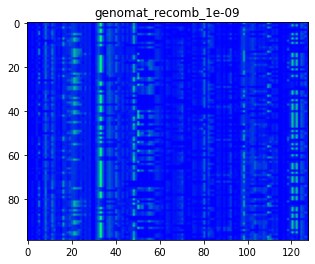

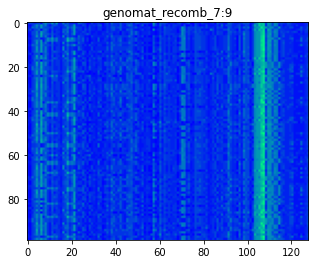

generating 10000 genotype matrices with different recomb from msprime for testing
Data simulation finished
Fitting discriminator model: 4
Model 4 trained for 1 epochs
Accuracy: Training - 0.8707    Validation - 0.5033

Model 4 trained for 2 epochs
Accuracy: Training - 0.9954    Validation - 0.9934

Model 4 trained for 3 epochs
Accuracy: Training - 0.9963    Validation - 1.0000

Model 4 trained for 4 epochs
Accuracy: Training - 0.9952    Validation - 1.0000

Model 4 trained for 5 epochs
Accuracy: Training - 0.9970    Validation - 1.0000

Model 4 trained for 6 epochs
Accuracy: Training - 0.9967    Validation - 1.0000

Model 4 trained for 7 epochs
Accuracy: Training - 0.9970    Validation - 1.0000

Model 4 trained for 8 epochs
Accuracy: Training - 0.9956    Validation - 1.0000

Model 4 trained for 9 epochs
Accuracy: Training - 0.9963    Validation - 1.0000

Model 4 trained for 10 epochs
Accuracy: Training - 0.9963    Validation - 1.0000

Model 4 trained for 11 epochs
Accuracy: Training - 

<Figure size 432x288 with 0 Axes>

In [5]:
# This command allows for eager execution, where a static graph is compiled.
# This allows the framework to apply global performance optimizations.
# Applicable to any function that take tensors as input.
#@tf.function 
def train_step(x, y):
  
  with tf.GradientTape() as tape:
    # Run the forward pass of the layer. The operations that the layer applies
    # to its inputs are going to be recorded on the GradientTape.
    logits = discriminator(x, training=True)
    loss_value = loss_fn(y, logits)
  grads = tape.gradient(loss_value, discriminator.trainable_weights)
  optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

  train_acc_metric.update_state(y, logits)
  return loss_value


#@tf.function
def test_step(x, y):
    val_logits = discriminator(x, training=False)
    val_acc_metric.update_state(y, val_logits)


samples = 99              #Number of sampled haplotypes --> number of rows in the genotype matrix
seqlen = 1e6              #Length of the randomly sampled genome region in bp
genmat_cols = 128         #Number of columns of the genotype matrix after rescaling
n_reps = 3000             #Number of repetitions --> number of genotype matrices
epochs = 50               #Number of epochs for discriminator training
batch_size = 32           #Size of each minibatch
param_name = 'recomb'     #The parameter to test
source = 'real data'      #Source of the data with the fixed parameters to infer
fixed=1e-9                #The fixed value for the parameter in set A
low=9                     #The lowest value for the randomly picked parameter in set B
high=7                    #The highest value for the randomly picked parameter in set B


# Prepare the training and validation datasets
xtrain, xval, ytrain, yval = generate_data(samples, seqlen, n_reps, genmat_cols, param_name, 
                                  fixed, low, high, minuslog=True, scale=True, source=source)
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((xval, yval))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare a list of genotype matrices from a range of values for the parameter for testing
xtest, param_values = generate_testdata(samples, seqlen, genmat_cols, param_name, low, high, 
                                        n=10000, minuslog=True)

print('Data simulation finished')

# Prepare the metrics, optimizer and loss function
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

for model in [4, 7, 9, 13]:

  img_paths = []

  # Build the discriminator
  print(f'Fitting discriminator model: {model}')
  discriminator = build_discriminator(model, in_shape=(samples, genmat_cols, 1))

  for epoch in range(1, epochs + 1):
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      loss_value = train_step(x_batch_train, y_batch_train)

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
      test_step(x_batch_val, y_batch_val)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    val_acc = val_acc_metric.result()
    print(f'Model {model} trained for {epoch} epochs')
    print("Accuracy: Training - %.4f    Validation - %.4f\n" % (float(train_acc), float(val_acc)))
    
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

    # Get discriminator prediction function over a range of values lin parameter space
    predictions = discriminator.predict(xtest)
    
    # Plot the discriminator prediction function
    name = f'D{model}test_{param_name}_{epoch}e_{low}:{high}'
    plot_average(param_values, predictions, param_name, name, bins=100)
    img_paths.append(f'/content/results/{name}.png')

  # Save the sequence of images as a gif
  images = [imageio.imread(filename) for filename in img_paths]
  imageio.mimsave(f'D{model}_{param_name}_{source}.gif', images, format='GIF', fps=5)
  keras.backend.clear_session()

In [0]:
!zip -r /content/download.zip /content/D*
files.download("/content/download.zip")

In [0]:
!rm -r /content/results/D*